# Colab Setup ⚙️

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/[3A ANLP] Lang Classification

/content/drive/My Drive/Colab Notebooks/[3A ANLP] Lang Classification


# Libraries

In [ ]:
import joblib
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import unicodedata
import re
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Data import


In [ ]:
# Read the data
# na_filter=False is used to avoid reading 'nan' (Minnan language) as a NaN value
train_submission = pd.read_csv("train_submission.csv", na_filter=False)
test_without_labels = pd.read_csv("test_without_labels.csv")

In [ ]:
train_submission.sample(5)

,Usage,Text,Label
43861,Public,觀世音菩薩普門品第二十五,wuu
123208,Public,Ashtahuangarin juchata rurashpa causajujmanda ...,qvi
2675,Public,Y ri Jesús xbe chic c'a apo richin xberubana' ...,cak
166965,Public,Ne itech ojtli yejyehuaticatcaj omemej ciegos....,ngu
32619,Public,Qızğanıçqa qarşı boks belän şöğellängän yeget...,bak


# Explore

In [ ]:
print("Nb of training examples:", len(train_submission))
print("Nb of test examples:", len(test_without_labels))
print("Nb of languages:", len(train_submission["Label"].unique()))

Nb of training examples: 190599
Nb of test examples: 190567
Nb of languages: 390


<Axes: title={'center': 'Texts distribution'}, xlabel='Label'>

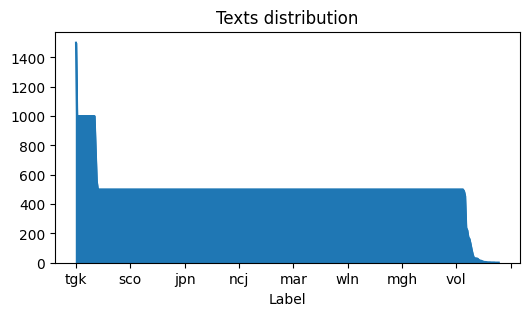

In [ ]:
train_submission["Label"].value_counts().plot(kind='area',title='Texts distribution' , figsize=(6,3))

Nb of dropped lang : 378 / 390


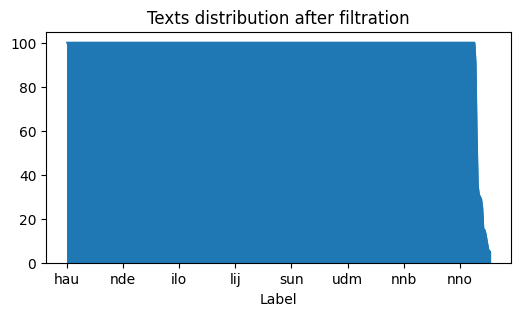

In [ ]:
# Make a smaller dataset by taking the first 100 samples of each class
train_submission_smaller = train_submission.groupby("Label").head(100)

# For our splits to work, each class must have at least 5 samples
train_submission_smaller = train_submission_smaller.groupby("Label").filter(
    lambda x: len(x) >= 5
)

train_submission_smaller["Label"].value_counts().plot(kind='area', title='Texts distribution after filtration' , figsize=(6,3))

print(f'Nb of dropped lang : {len(train_submission_smaller["Label"].unique())} / {len(train_submission["Label"].unique())}')

In [ ]:
def script_count(text):
    # Define Unicode character ranges for different scripts
    # Major alphabets
    scripts = {
        "Latin": r"[\u0041-\u007A]",  # A-Z, a-z
        "Cyrillic": r"[\u0400-\u04FF]",  # Cyrillic characters
        "Arabic": r"[\u0600-\u06FF]",  # Arabic script
        "Devanagari": r"[\u0900-\u097F]",  # Hindi, Sanskrit
        "Chinese": r"[\u4E00-\u9FFF]",  # Chinese characters
    }

    # Check which script appears the most
    script_counts = {script: len(re.findall(regex, text)) for script, regex in scripts.items()}
    return script_counts

def detect_script(text):
    script_counts = script_count(text)
    most_common_script = max(script_counts, key=script_counts.get)
    return most_common_script, script_counts[most_common_script] / len(text)

In [ ]:
train_submission["script"] = train_submission["Text"].apply(lambda t : detect_script(t)[0])
train_submission["percentage"] = train_submission["Text"].apply(lambda t : detect_script(t)[1] * 100)

In [ ]:
train_submission.head()

,Usage,Text,Label,script,percentage
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau,Arabic,87.229437
1,Public,Filmen forteller historien om Will Hunting en...,nob,Latin,83.132530
2,Public,An Arthrostylidium berryi in uska species han ...,wln,Latin,84.523810
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh,Latin,86.643836
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh,Latin,86.131387


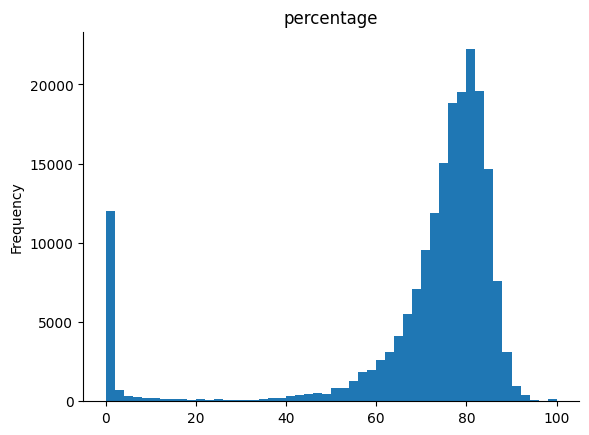

In [ ]:
# @title percentage

train_submission['percentage'].plot(kind='hist', bins=50, title='percentage')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
rare_alphabet = train_submission.where(train_submission['percentage'] < 40).dropna()
print(f'Nb of texts with a rare alphabet : {len(rare_alphabet)}')
print(f'Nb of lang with a rare alphabet : {len(rare_alphabet["Label"].unique())}')
rare_alphabet.head()

Nb of texts with a rare alphabet : 15472
Nb of lang with a rare alphabet : 83


,Usage,Text,Label,script,percentage
10,Public,જ્યાં સુધી કોઈ પોસ્ટ પોસ્ટ ખાસ કરીને કહે છે કે...,guj,Latin,0.000000
29,Public,ନୂଆଦିଲ୍ଲୀ: ନବେ ଦଶକ ସମୟର କଥା। ସେହି ସମୟରେ କ୍ଷୁଦ୍...,ori,Devanagari,1.096892
43,Public,ಕಾರ್ಯಕ್ರಮದಲ್ಲಿ ಮುಖ್ಯ ಅತಿಥಿಯಾಗಿ ಪಾಲ್ಗೊಂಡಿದ್ದ ಕರ...,kan,Latin,0.000000
55,Public,ዛሬም ቢሆን ይህ ጸጋ እግዚአብሔርን እንደ እግዚአብሔርነቱ በንጽህና በቅድ...,amh,Latin,0.000000
56,Public,ຂະແໜງກະສິກຳຢູ່ ໄຕງວຽນ ໄດ້ປະກອບສ່ວນ ຊຸກຍູ້ເສດຖະ...,lao,Latin,0.000000


In [ ]:
# Create a copy of the DataFrame
train_submission_copy = train_submission.copy()

# Change the 'script' of entries with 'percentage' < 0.4 to 'Other'
train_submission_copy.loc[train_submission_copy['percentage'] < 40, 'script'] = 'Other'

# Show the repartitions of 'script'
script_repartitions = train_submission_copy['script'].value_counts(normalize=True)
script_repartitions

,proportion
script,
Latin,0.723661
Cyrillic,0.085305
Other,0.081176
Arabic,0.064885
Devanagari,0.031396
Chinese,0.013578


# Train-test splitting


In [ ]:
# Make a smaller dataset by taking the first 100 samples of each class
train_submission_smaller = train_submission.groupby("Label").head(100)

# For our splits to work, each class must have at least 5 samples
train_submission_smaller = train_submission_smaller.groupby("Label").filter(
    lambda x: len(x) >= 5
)

# --- Train test split ---
# test = 20% (each class gets at least 1 sample)
# train = 80% (each class gets at least 4 samples)
train_indices = []
test_indices = []

# Random number generator
rng = np.random.default_rng(42)

for label, group in train_submission_smaller.groupby("Label"):
    n = len(group)
    test_count = round(n * 0.2)

    group_indices = group.index.to_numpy()

    selected_test = rng.choice(group_indices, size=test_count, replace=False)
    selected_train = np.setdiff1d(group_indices, selected_test)

    test_indices.extend(selected_test.tolist())
    train_indices.extend(selected_train.tolist())

test_dataset = train_submission_smaller.loc[test_indices]
X_test = test_dataset["Text"].to_numpy()
y_test = test_dataset["Label"].to_numpy()

train_dataset = train_submission_smaller.loc[train_indices].reset_index(drop=True)
X_train = train_dataset["Text"].to_numpy()
y_train = train_dataset["Label"].to_numpy()


# --- Split the train dataset into two folds ---
# For each fold:
# test = 20% (each class gets at least 1 sample)
# train = 80% (each class gets at least 1 samples)
def custom_split(train_dataset: pd.DataFrame, random_seed):
    train_indices = []
    test_indices = []

    rng = np.random.default_rng(random_seed)

    for label, group in train_dataset.groupby("Label"):
        n = len(group)
        # Compute inner test count ~20% of m, but at least 1
        test_count = max(1, round(n * 0.2))
        # Ensure at least 1 remains in the train fold:
        group_indices = group.index.to_numpy()
        selected_test = rng.choice(group_indices, size=test_count, replace=False)
        selected_train = np.setdiff1d(group_indices, selected_test)

        test_indices.extend(selected_test.tolist())
        train_indices.extend(selected_train.tolist())

    return np.array(train_indices), np.array(test_indices)


# Generate two different folds with different random seeds
fold1_train_idx, fold1_test_idx = custom_split(train_dataset, random_seed=42)
fold2_train_idx, fold2_test_idx = custom_split(train_dataset, random_seed=43)

# Cross-validation splits
cv = [(fold1_train_idx, fold1_test_idx), (fold2_train_idx, fold2_test_idx)]

# Clean up
del train_indices, test_indices, train_dataset, test_dataset

# Model


In [ ]:
# Create a pipeline that first converts the text into a matrix of TF-IDF features and then trains a logistic regression classifier
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer(analyzer="char")),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", LogisticRegression()),
    ]
)

def create_pipeline(h_params):
    if h_params is None:
        return Pipeline(
        [
            ("tfidf", TfidfVectorizer(analyzer="char",
                                      ngram_range=(1,3),
                                      max_features=5000)),
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", LogisticRegression(C=10.0,
                                       max_iter=1000)),
        ]
        )

    analyzer = h_params['analyzer'] if 'analyzer' in h_params else 'char'
    ngram_range = h_params['ngram_range'] if 'ngram_range' in h_params else (1,3)
    max_features = h_params['max_features'] if 'max_features' in h_params else 5000
    C = h_params['C'] if 'C' in h_params else 10.0

    return Pipeline(
        [
            ("tfidf", TfidfVectorizer(analyzer=analyzer,
                                      ngram_range=ngram_range,
                                      max_features=max_features)),
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", LogisticRegression(C=C,
                                      max_iter=1000)),
        ]
    )

In [ ]:
class MultiScriptClassifier(BaseEstimator, ClassifierMixin):

    # Script (alphabet) detection --> TfidfVectorizer --> LogisticRegression

    def __init__(self, model_params = None, threshold = 0.4):
        if model_params is None:
            model_params = {
                "Other": None
            }

        self.model_params = model_params

        self.models = {
            key : create_pipeline(value) for key, value in self.model_params.items()
        }

        self.threshold = threshold

    def fit(self, X, y):
        """Train separate classifiers per script"""
        print("params : ", self.model_params, self.threshold)
        X = list(X)  # list format
        script_data = defaultdict(list)
        supported_scripts = self.model_params.keys()

        for text, label in zip(X, y):
            script, script_percentage = detect_script(text)
            if (script not in supported_scripts) or (script_percentage <= self.threshold):
                script = "Other"
            script_data[script].append((text, label))

        # Ensure all script models exist before training
        for script in self.model_params.keys():
            if script not in script_data:
                script_data[script] = []

        self.models = {}  # Reset before training

        for script, samples in script_data.items():
            pipeline = create_pipeline(self.model_params[script])
            if samples:
                texts, labels = zip(*samples)
                pipeline.fit(texts, labels)
            self.models[script] = pipeline  # Ensure all models are stored

        return self

    def predict(self, texts):
      predictions = [None] * len(texts)  # Pre-allocate with None
      supported_scripts = self.model_params.keys()
      script_groups = defaultdict(list)  # Store texts by script
      group_indices = defaultdict(list) # store original indices

      # Group texts by detected script and store indices
      for i, text in enumerate(texts):
          script, script_percentage = detect_script(text)
          if (script not in supported_scripts) or (script_percentage <= self.threshold):
              script = "Other"
          script_groups[script].append(text)
          group_indices[script].append(i) # Store the index of the text

      # Predict on groups
      for script, group_texts in script_groups.items():
          model = self.models[script]
          group_predictions = model.predict(group_texts)

          # Insert group predictions at correct positions in the main list
          for i, pred in zip(group_indices[script], group_predictions):
              predictions[i] = pred

      return predictions

    def score(self, X, y):
        """Compute accuracy"""
        return accuracy_score(y, self.predict(X))

    def get_params(self, deep=True):
        return {
            "model_params": self.model_params,
            "threshold": self.threshold
        }

pipeline_multi = Pipeline([
    ("classifier_multi", MultiScriptClassifier())
    ])

# Grid search


In [ ]:
# Use GridSearchCV to find the best hyperparameters

param_grid = {
    "tfidf__ngram_range": [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)],
    "tfidf__max_features": [5000, 10000, 15000],
    "clf__C": [1, 10],
}

# For simple pipeline
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring="accuracy", refit=True, verbose=3, n_jobs=-1
)

In [ ]:
scripts = ["Latin", "Cyrillic", "Arabic", "Devanagari", "Chinese"]
scripts_combinations = []
# for i in range(len(scripts) + 1):
for i in range(len(scripts) + 1):
    scripts_combinations += list(itertools.combinations(scripts,i))

# Trying different combinations of scripts
comb_scripts_dict_list = []
for comb in scripts_combinations:
    scripts_dict = {scripts : {"C": 10.0, "ngram_range": (1, 3), "max_features": 1000, 'analyzer': 'char'} for scripts in list(comb) +  ["Other"]}
    comb_scripts_dict_list.append(scripts_dict)
    # print(scripts_dict)
print('Nb of scripts combinations : ', len(comb_scripts_dict_list))

# Trying 'char' or 'word' analyzer for scripts
analyzers = ["char", "word"]
analyzer_combinations = []

comb_analyzer_dict_list = []
for combination in itertools.product(analyzers, repeat=len(scripts)):
    # Create a dictionary for this combination
    combination_dict = {script: {'analyzer':analyzer} for script, analyzer in zip(scripts, combination)}
    combination_dict['Other'] = {'analyzer': 'char', 'max_features': 10000}
    comb_analyzer_dict_list.append(combination_dict)
    # print(combination_dict)
print('Nb of analyzers combinations : ', len(comb_analyzer_dict_list))

Nb of scripts combinations :  1
Nb of analyzers combinations :  32


In [ ]:
param_grid_multi = {
    "classifier_multi__model_params": [{
        "Latin": {"C": 10.0, "ngram_range": (1, 3), "max_features": 15000, 'analyzer': 'char'},
        "Cyrillic": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Arabic": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Devanagari": {"C": 10.0, "ngram_range": (1, 3), "max_features": 5000, 'analyzer': 'char'},
        "Chinese": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Other": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'}
    }],
    "classifier_multi__threshold": [0.1, 0.2, 0.3, 0.4, 0.5]
    }

param_grid_alphabets_multi = {
    "classifier_multi__model_params": comb_scripts_dict_list,
    "classifier_multi__threshold": [0.4]
    }

param_grid_analyzer_multi = {
    "classifier_multi__model_params": comb_analyzer_dict_list,
    "classifier_multi__threshold": [0.4]
    }

# BEST :
#	{'Latin': {'C': 10.0, 'ngram_range': (1, 3), '...
# t = 0.4
# SCORE : 0.829368

grid_search_multi = GridSearchCV(
    pipeline_multi, param_grid_alphabets_multi, cv=cv, scoring="accuracy", refit=True, verbose=3, n_jobs=-1
)

In [ ]:
# Run the grid search for multiple scipts (alphabets) pipeline

grid_search_multi.fit(X_train, y_train)

In [ ]:
# Create a DataFrame with the hyperparameter combinations and their cross-validation accuracies
results_df = pd.DataFrame(
    [param_dict.values() for param_dict in grid_search_multi.cv_results_["params"]],
    columns=grid_search_multi.cv_results_["params"][0].keys(),
)
results_df["classifier_multi__alphabets"] = results_df["classifier_multi__model_params"].apply(lambda d : [l[:3] for l in d.keys()])
results_df.drop(columns=["classifier_multi__model_params"], inplace=True)

results_df["mean_test_score"] = grid_search_multi.cv_results_["mean_test_score"]
results_df.sort_values("mean_test_score", ascending=False, ignore_index=True, inplace=True)
results_df

In [ ]:
# Plot
plt.figure(figsize=(6, 6))
results_df["classifier_multi__alphabets"] = results_df["classifier_multi__alphabets"].apply(str)
plt.barh(results_df["classifier_multi__alphabets"], results_df["mean_test_score"], color='skyblue')
plt.xlabel("Mean Test Score")
plt.ylabel("Alphabet Groups")
plt.title("Performance of Different Alphabet Groups")
plt.gca().invert_yaxis()  # Invert to have the best score on top

plt.show()

# Best model


In [ ]:
# Retain the best model from grid search
best_model = grid_search_multi.best_estimator_
print("Best Hyperparameters:")
print(grid_search_multi.best_params_)

Best Hyperparameters:
{'classifier_multi__model_params': {'Latin': {'analyzer': 'char'}, 'Cyrillic': {'analyzer': 'char'}, 'Arabic': {'analyzer': 'char'}, 'Devanagari': {'analyzer': 'char'}, 'Chinese': {'analyzer': 'char'}, 'Other': {'analyzer': 'char', 'max_features': 10000}}, 'classifier_multi__threshold': 0.4}


In [ ]:
# ALTERNATIVE

best_model = MultiScriptClassifier(model_params = {
        "Latin": {"C": 10.0, "ngram_range": (1, 3), "max_features": 15000, 'analyzer': 'char'},
        "Cyrillic": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Arabic": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Devanagari": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Chinese": {"C": 10.0, "ngram_range": (1, 3), "max_features": 10000, 'analyzer': 'char'},
        "Other": {"C": 10.0, "ngram_range": (1, 3), "max_features": 15000, 'analyzer': 'char'}
        },  threshold = 0.4)

In [ ]:
best_model.fit(X_train, y_train)

params :  {'Latin': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 15000, 'analyzer': 'char'}, 'Cyrillic': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Arabic': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Devanagari': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Chinese': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Other': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 15000, 'analyzer': 'char'}} 0.4


MultiScriptClassifier(model_params={'Arabic': {'C': 10.0, 'analyzer': 'char',
                                               'max_features': 10000,
                                               'ngram_range': (1, 3)},
                                    'Chinese': {'C': 10.0, 'analyzer': 'char',
                                                'max_features': 10000,
                                                'ngram_range': (1, 3)},
                                    'Cyrillic': {'C': 10.0, 'analyzer': 'char',
                                                 'max_features': 10000,
                                                 'ngram_range': (1, 3)},
                                    'Devanagari': {'C': 10.0,
                                                   'analyzer': 'char',
                                                   'max_features': 10000,
                                                   'ngram_range': (1, 3)},
                                    'Latin': {'C': 10.0, 'analyzer': 'char',
                                              'max_features': 15000,
                                              'ngram_range': (1, 3)},
                                    'Other': {'C': 10.0, 'analyzer': 'char',
                                              'max_features': 15000,
                                              'ngram_range': (1, 3)}})

In [ ]:
# Predict the language of the test data
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 1.000


In [ ]:
# Store the best model
joblib.dump(best_model, "best_model___.joblib")

In [ ]:
# Show the size of the matrix of TF-IDF features
vect = best_model.models['Other'].named_steps["tfidf"]
X_train_vectorized = vect.transform(X_train)
print(
    "(Number of samples, Number of features) =",
    X_train_vectorized.shape,
)

# Show an example of the vectorization
print()
print("Example of the top 10 features for the first sample:")
print(X_train[0])
pd.Series(
    X_train_vectorized[0].toarray()[0],
    index=vect.get_feature_names_out(),
    name="TF-IDF",
).sort_values(ascending=False).head(10)

(Number of samples, Number of features) = (29415, 15000)

Example of the top 10 features for the first sample:
Саид иан дыҟам  иаб дыҟам  ишырҳәауа еиԥш  дмаҭазаҵәуп  ус дшааиуаз анасыԥ изылбааԥшын иҵәҩаншьап мыӡыр ҟалап ҳәа гәыӷрала иназԥшит уи игәараҭа.


,TF-IDF
а,0.859146
и,0.372200
д,0.163201
н,0.158803
м,0.128721
р,0.125497
л,0.097921
с,0.095282
,0.094038
б,0.071970


# Predictions for submission


In [ ]:
# Final train on the whole training set:
best_model.fit(train_submission["Text"], train_submission["Label"])

params :  {'Latin': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 15000, 'analyzer': 'char'}, 'Cyrillic': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Arabic': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Devanagari': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Chinese': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 10000, 'analyzer': 'char'}, 'Other': {'C': 10.0, 'ngram_range': (1, 3), 'max_features': 15000, 'analyzer': 'char'}} 0.4


MultiScriptClassifier(model_params={'Arabic': {'C': 10.0, 'analyzer': 'char',
                                               'max_features': 10000,
                                               'ngram_range': (1, 3)},
                                    'Chinese': {'C': 10.0, 'analyzer': 'char',
                                                'max_features': 10000,
                                                'ngram_range': (1, 3)},
                                    'Cyrillic': {'C': 10.0, 'analyzer': 'char',
                                                 'max_features': 10000,
                                                 'ngram_range': (1, 3)},
                                    'Devanagari': {'C': 10.0,
                                                   'analyzer': 'char',
                                                   'max_features': 10000,
                                                   'ngram_range': (1, 3)},
                                    'Latin': {'C': 10.0, 'analyzer': 'char',
                                              'max_features': 15000,
                                              'ngram_range': (1, 3)},
                                    'Other': {'C': 10.0, 'analyzer': 'char',
                                              'max_features': 15000,
                                              'ngram_range': (1, 3)}})

In [ ]:
def get_file_size_with_unit(file_path):
    """Gets file size with appropriate unit (bytes, KB, MB, GB)."""
    size_in_bytes = os.path.getsize(file_path)
    units = ["bytes", "KB", "MB", "GB", "TB"]
    unit_index = 0
    while size_in_bytes >= 1024 and unit_index < len(units) - 1:
        size_in_bytes /= 1024
        unit_index += 1
    return f"{size_in_bytes:.2f} {units[unit_index]}"

# Store the best model
joblib.dump(best_model, "best_model_.joblib")
print('Model size:', get_file_size_with_unit("best_model_.joblib"))

Model size: 56.34 MB


In [ ]:
# Load the model
best_model = joblib.load("best_model_.joblib")

In [ ]:
# Predict the language of the test data
y_pred = best_model.predict(test_without_labels["Text"])

# Save the predictions to a CSV file
test_submission = pd.DataFrame(
    {"ID": range(1, len(test_without_labels) + 1), "Label": y_pred}
)
test_submission.to_csv("test_submission.csv", index=False)